Question 1 Covariates 0320

In [15]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels import IV2SLS
from tqdm import tqdm
random.seed(42)

In [16]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")

# DAG without coviariates

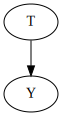

In [17]:
g = gr.Digraph()
g.edge("T", "Y")


g

# DAG with coviariates

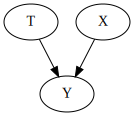

In [18]:
g = gr.Digraph()
g.edge("T", "Y")

g.edge("X", "Y")

g

In [19]:
def generate_cov(dim, corr):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc, axis=0)


def generate_multnorm(nobs, corr, nvar):
    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc=1, scale=.5, size=(nvar, 1)))) ** (1 / 2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i], std[i], nobs), (nobs, -1)))

    normvars = np.concatenate(acc, axis=1)

    cov = generate_cov(nvar, corr)
    C = np.linalg.cholesky(cov)

    X = np.transpose(np.dot(C, np.transpose(normvars)))
    return X


def randomize_treatment(N, prob=0.5):
    return np.random.binomial(1, prob, N).reshape([N, 1])


def generate_data(tau, N, p, corr=0.5):
    """p is the number of covariates"""
    X = generate_multnorm(N, corr, p)
    T = randomize_treatment(N) 
    global beta
    global err
    err = np.random.normal(0, 1, [N, 1])
    beta = np.random.normal(5, 5, [p, 1])

    Y = tau * T + X @ beta +  err
    return Y, T, X


def randomized_experiment(tau, N, p, violate=False):
 
    Y, T, X = generate_data(tau, N, p)
    if violate==False:
        covars = np.concatenate([T, X], axis=1)
    # violate here means not controlling covariates
    if violate==True:
        covars = np.concatenate([T], axis=1)
    mod = sm.OLS(Y, covars)
    res = mod.fit()
    tauhat = res.params[0]
    se_tauhat = res.HC1_se[0]
    return tauhat, se_tauhat


def get_bias_rmse_size(true_value, estimate: list, standard_error: list, cval = 1.96):
    R = len(estimate)

    b = estimate - np.ones([R, 1]) * true_value
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b ** 2))
    tval = b / standard_error
    size = np.mean(1 * (np.abs(tval) > cval))
    return bias, rmse, size

# Without controlling covariates(violate=True)

In [20]:
N = 1000  # number of observations
tau = 5  # treatment effect
p = 10  # number of covariates
R = 500  # number of experiments

In [21]:
# This is the case when the assumption holds
tauhats = []
se_tauhats = []
for _ in tqdm(range(R)):
    tauhat, se_tauhat = randomized_experiment(tau, N, p, violate=True)
    tauhats.append(tauhat)
    se_tauhats.append(se_tauhat)
    
tauhats = np.array(tauhats).reshape([R, 1])
se_tauhats = np.array(se_tauhats).reshape([R, 1])
print("Average estimate value and standard error are:", tauhats.mean(), se_tauhats.mean())

bias, rmse, size = get_bias_rmse_size(tau, tauhats, se_tauhats)
print("bias, rmse, size are:", round(bias, 8), round(rmse, 8), round(size, 8))

100%|██████████| 500/500 [00:00<00:00, 1173.98it/s]

Average estimate value and standard error are: 4.923524638636127 1.6802574866577331
bias, rmse, size are: -0.07647536 1.79008231 0.044


In [22]:
N = 100  # number of observations
tau = 5  # treatment effect
p = 10  # number of covariates
R = 500
# This is the case when the assumption holds
tauhats = []
se_tauhats = []
for _ in tqdm(range(R)):
    tauhat, se_tauhat = randomized_experiment(tau, N, p, violate=True)
    tauhats.append(tauhat)
    se_tauhats.append(se_tauhat)
    
tauhats = np.array(tauhats).reshape([R, 1])
se_tauhats = np.array(se_tauhats).reshape([R, 1])
print("Average estimate value and standard error are:", tauhats.mean(), se_tauhats.mean())

bias, rmse, size = get_bias_rmse_size(tau, tauhats, se_tauhats)
print("bias, rmse, size are:", round(bias, 8), round(rmse, 8), round(size, 8))

100%|██████████| 500/500 [00:00<00:00, 2077.94it/s]

Average estimate value and standard error are: 4.51670798830412 5.3710503550939706
bias, rmse, size are: -0.48329201 5.95068003 0.072


# Real World Example
 The real life example would be say, run an experiment where you seperate some students into two groups and give them a particular task, one of the groups with motivation like lipstics and the other without it. And the goal is to see how the motivation improves their task performance, without considering their characteristics or personalities like family background etc.

# Controlling covariates(violate=False)
$Y = \tau * T + X @ \beta +  err$

In [23]:
N = 1000  # number of observations
tau = 5  # treatment effect
p = 10  # number of covariates
R = 500  # number of experiments
# This is the case when the assumption is violated
tauhats = []
se_tauhats = []
for _ in tqdm(range(R)):
    tauhat, se_tauhat = randomized_experiment(tau, N, p, violate=False)
    tauhats.append(tauhat)
    se_tauhats.append(se_tauhat)
    
tauhats = np.array(tauhats).reshape([R, 1])
se_tauhats = np.array(se_tauhats).reshape([R, 1])
print("Average estimate value and standard error are:", tauhats.mean(), se_tauhats.mean())

bias, rmse, size = get_bias_rmse_size(tau, tauhats, se_tauhats)
print("bias, rmse, size are:", round(bias, 8), round(rmse, 8), round(size,8 ))

100%|██████████| 500/500 [00:00<00:00, 852.06it/s]

Average estimate value and standard error are: 5.001428056729671 0.044910378477307784
bias, rmse, size are: 0.00142806 0.04516553 0.062


In [24]:
N = 100  # number of observations
tau = 5  # treatment effect
p = 10  # number of covariates
R = 500
# This is the case when the assumption is violated
tauhats = []
se_tauhats = []
for _ in tqdm(range(R)):
    tauhat, se_tauhat = randomized_experiment(tau, N, p, violate=False)
    tauhats.append(tauhat)
    se_tauhats.append(se_tauhat)
    
tauhats = np.array(tauhats).reshape([R, 1])
se_tauhats = np.array(se_tauhats).reshape([R, 1])
print("Average estimate value and standard error are:", tauhats.mean(), se_tauhats.mean())

bias, rmse, size = get_bias_rmse_size(tau, tauhats, se_tauhats)
print("bias, rmse, size are:", round(bias, 4), round(rmse, 4), round(size,4 ))

100%|██████████| 500/500 [00:00<00:00, 1528.85it/s]

Average estimate value and standard error are: 5.000616783864985 0.14907837790046097
bias, rmse, size are: 0.0006 0.1515 0.064


# Real World Example
The real life example would be say, run an experiment where you seperate some students into two groups and give them a particular task, one of the groups with motivation like lipstics and the other without it. And the goalis to see how the motivation improves their task performance.
In addition, we will add covariates including age, family background(Single parent or not), parents' education level, ethnic, gender,height, birth period,family income, family location, household income.After controlling these covariates, we continue study how the motivation improves theier task performance.
